In [72]:
import matplotlib.pyplot as plt
import cv2

from byotrack import Video, VideoTransformConfig

from byotrack.implementation.detector.stardist import StarDistDetector

import skimage.io as iio
from byotrack.video.transforms import ChannelSelect, ChannelAvg, ScaleAndNormalize 
from PIL import Image
import numpy as np #can switch this out for pytorch at somepoint - notation is identical
from roifile import ImagejRoi, ROI_TYPE, ROI_OPTIONS #for saving as an imageJ roi file
from stardist.models import StarDist2D
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
import pathlib
from tqdm import tqdm

tifpath = '/home/noah/Desktop/cellsegtest/segTestNew/shortStack_adjusted' #path to sequence of tiff files

In [35]:
#reader funtion for tif sequences 
def Read_Data_TIFseq(vid_path):
    # positions = (pd.read_csv(csv_path,usecols=['TrackID','t','x','y'])).values
    vid = iio.ImageCollection(vid_path + '/*.tif').concatenate() #concatonate to numpyarray
    # red_vid = iio.ImageCollection(red_vid_path + '/*.tif')
    vid = vid.reshape(vid.shape[0], vid.shape[1], vid.shape[2], 1)
    #vid = np.asarray([csbdeepNormaliser(frame) for frame in vid])
    return vid


def coordReshaper_IJ(coords): #reshaping for use with imageJ rois
    coords_reshaped = []
    for i in range(len(coords[0])):
        xdata = coords[0][i]
        ydata = coords[1][i]
        coords_reshaped.append([ydata,xdata])
    return coords_reshaped

def reshape_all_rois(all_rois):
    allROIs = []
    for rois in all_rois:
        roishaped = coordReshaper_IJ(rois)
        allROIs.append(roishaped)
    return allROIs

def convert_to_ImageJ(allROIs):
    ijrois = []
    for roi in allROIs:
        roimask = ImagejRoi.frompoints(roi)
        roimask.roitype = ROI_TYPE.POLYGON
        roimask.options |= ROI_OPTIONS.SHOW_LABELS
        ijrois.append(roimask)
    return ijrois


def coordReshaper_CV_contours(coords):

    '''
    Reshape contours generated by StarDist for use with openCV's display contours function
    '''

    coords_reshaped = []
    for contour in np.flip(coords,1): #hard to find this solution - coords need to be flipped, they are read clockwise by openCV and I guess this is not how they are written by StarDist. Results in contours plotted transposed from desired without flipping array.:)
        for i in range(len(contour[0])):
            coords_reshaped.append([contour[0][i], contour[1][i]]) #instead of flipping, these can be read y,x too [i.e. coords_reshaped.append([contour[1][i], contour[0][i]])]
    
    cv_format_contours = (np.array(coords_reshaped).reshape((-1,1,2)).astype(np.int32)) #https://stackoverflow.com/questions/14161331/creating-your-own-contour-in-opencv-using-python
    return cv_format_contours

def generate_contours(image, detector):
    segmentation, data = detector._model.predict_instances(image, prob_thresh=detector.prob_threshold, nms_thresh=detector.nms_threshold, predict_kwargs={"verbose": 0})
    contours = coordReshaper_CV_contours(data['coord'])
    return contours


def visualise_all_contours_cv(image, cvContours, colour = None):
    '''
    Takes contours in opencv format and plots them over image
    https://stackoverflow.com/questions/57576686/how-to-overlay-segmented-image-on-top-of-main-image-in-python
    '''

    # image_contours = image.copy()
    if colour == None:
        colour = (0,255,255)
    # Iterate over all contours
    for i,c in enumerate(cvContours):
        try:
            
            #for different colours - can define colour in this loop for each contour
            
            # Outline contour in that colour on main image, line thickness=1
            cv2.drawContours(image,[c],-1,colour,1, cv2.LINE_8)
        except Exception as e:
            print(e)
            break

In [36]:
class stardist():

    def __init__(self, modelpath):
        path = pathlib.Path(model_path)
        self._model = StarDist2D(None, path.name, str(path.parent))
        self.prob_threshold: float = self._model.thresholds.prob
        self.nms_threshold: float = self._model.thresholds.nms
    
    def detect(self, batch):
        detections_list = []
        data_list = []
        for image in tqdm(batch):
            segmentation, data = self._model.predict_instances(image, prob_thresh=self.prob_threshold, nms_thresh=self.nms_threshold, predict_kwargs={"verbose": 0})
            detections_list.append(segmentation)
            data_list.append(data)
        return detections_list, data_list

        

In [37]:
video = Read_Data_TIFseq(tifpath)

# normalize video
mini = np.quantile(video, 0.005)
maxi = np.quantile(video, 0.999)

np.clip(video, mini, maxi, video)
video = (video - mini) / (maxi - mini)

In [38]:
model_path = "/home/noah/Desktop/STARDIST_CONFOCAL/NEWEST TdT MODELS/10X_IMAGES_ONLY"

detector = stardist(model_path)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.592132, nms_thresh=0.3.


In [39]:
# model_path = "/home/noah/Desktop/STARDIST_CONFOCAL/NEWEST TdT MODELS/10X_IMAGES_ONLY"
# detector = StarDistDetector(model_path, batch_size=5)

In [40]:
#Set model parameters for your dataset

vidCopy = video[0:50] #test batch
scale = 1

global frameID
global frame
global frame_cv
global contours

frameID = 0
frame = vidCopy[frameID].copy()
frame_cv = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
frame_cv = cv2.cvtColor(frame_cv, cv2.COLOR_GRAY2BGR)
h, w = frame.shape[0:2]

#initialise plotting parameters with default values - converted to 0-100 range for openCV trackbars
probabilityThreshold = int(detector.prob_threshold*100) 
nmsThreshold = int(detector.nms_threshold*100)

contours = generate_contours(frame, detector) 

# window_name = 'Frame', f'Frame {frameID} / {len(detections_sequence_test)} - Number of detections: {len(detections_sequence_test[i])}'
window_name = 'Paramater Test - Segmentation   (Press Q to Quit)'

try:

    #create and rescale window
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, h*scale, w*scale)

    #Frame Trackbar
    def update_frame(x): #callback function for trackbar - default argument is the position of the track bar
        global contours
        global frame
        global frame_cv

        frame = vidCopy[x].copy()
        frame_cv = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        frame_cv = cv2.cvtColor(frame_cv, cv2.COLOR_GRAY2BGR)
        contours = generate_contours(frame, detector) 
    cv2.createTrackbar('Frame',window_name,0,len(vidCopy)-1,update_frame)

    #Probability Trackbar
    def update_probability_threshold(x):
        detector.prob_threshold = (x+1)/100 
        update_frame(frameID)
    cv2.createTrackbar('Probability Threshold', window_name, probabilityThreshold, 99, update_probability_threshold)

    #Overlap Trackbar
    def update_overlap_threshold(x):
        detector.nms_threshold = (x+1)/100
        update_frame(frameID)
    cv2.createTrackbar('Overlap Threshold', window_name, nmsThreshold, 99, update_overlap_threshold)

except Exception as e:
    print(e)


while True:
    try:

        frameID = cv2.getTrackbarPos('Frame',window_name)
        # cv2.imshow(window_name, video[frameID])
        visualise_all_contours_cv(frame_cv, contours)
        cv2.imshow(window_name, frame_cv)

        probabilityThreshold = cv2.getTrackbarPos('Probability Threshold', window_name)/100
        nmsThreshold = cv2.getTrackbarPos('Overlap Threshold', window_name)/100

        #exit on q
        if cv2.waitKey(5) == ord('q'):
            # press q to terminate the loop
            cv2.destroyAllWindows()
            break

    except Exception as e:
        print(e)
        cv2.destroyAllWindows()
        break
    
cv2.destroyAllWindows()

print('Probability Threshold: ', probabilityThreshold)
print('nms Threshold: ', nmsThreshold)



QObject::moveToThread: Current thread (0x55f30a42ba10) is not the object's thread (0x55f30a2ca3d0).
Cannot move to target thread (0x55f30a42ba10)

QObject::moveToThread: Current thread (0x55f30a42ba10) is not the object's thread (0x55f30a2ca3d0).
Cannot move to target thread (0x55f30a42ba10)

QObject::moveToThread: Current thread (0x55f30a42ba10) is not the object's thread (0x55f30a2ca3d0).
Cannot move to target thread (0x55f30a42ba10)

QObject::moveToThread: Current thread (0x55f30a42ba10) is not the object's thread (0x55f30a2ca3d0).
Cannot move to target thread (0x55f30a42ba10)

QObject::moveToThread: Current thread (0x55f30a42ba10) is not the object's thread (0x55f30a2ca3d0).
Cannot move to target thread (0x55f30a42ba10)

QObject::moveToThread: Current thread (0x55f30a42ba10) is not the object's thread (0x55f30a2ca3d0).
Cannot move to target thread (0x55f30a42ba10)

QObject::moveToThread: Current thread (0x55f30a42ba10) is not the object's thread (0x55f30a2ca3d0).
Cannot move to tar

Probability Threshold:  0.59
nms Threshold:  0.3


In [41]:
#run detection on full video
print('Probability Threshold: ', probabilityThreshold)
print('nms Threshold: ', nmsThreshold)
user_confirmation = input('Confirm parameters (y/n)')

if user_confirmation == 'y':
    detections_sequence, data_sequence = detector.detect(video)
else:
    print('Aborting Segmentstion')

Probability Threshold:  0.59
nms Threshold:  0.3


100%|██████████| 20/20 [00:04<00:00,  4.29it/s]


In [122]:
# convert to a format for byotracks
sequence = byotracks.Detections()
np.flip(data_sequence[0]['points'],1)

NameError: name 'byotracks' is not defined

In [68]:
data_sequence[0]['points'][:,1][0] #shape is y,x for some reason... did I mess something up?
# print(video[0].shape)

344

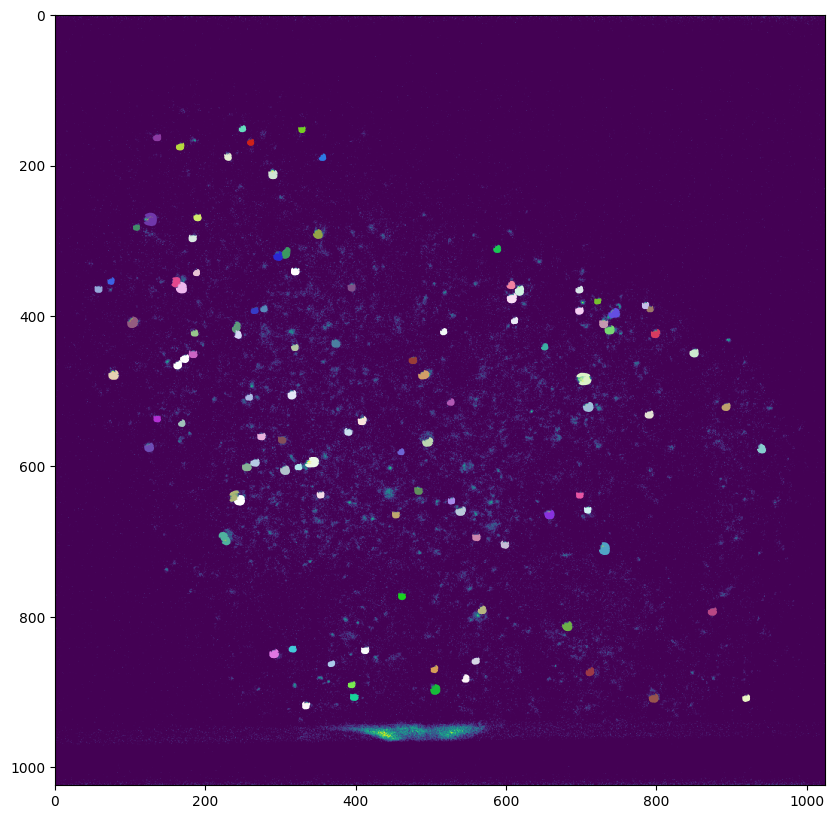

In [124]:
 coord, points, prob = data_sequence[0]['coord'], data_sequence[0]['points'], data_sequence[0]['prob']
 plt.figure(figsize=(13,10))
 plt.ylim(1024, 0)
 plt.xlim(0,1024)
 plt.imshow(video[0].reshape(video[0].shape[0], video[0].shape[1]))
#adding an imshow() plot here changes the way the axes count...
_draw_polygons(coord, points, prob, show_dist=True)
plt.figsize=(25,25)
plt.show()


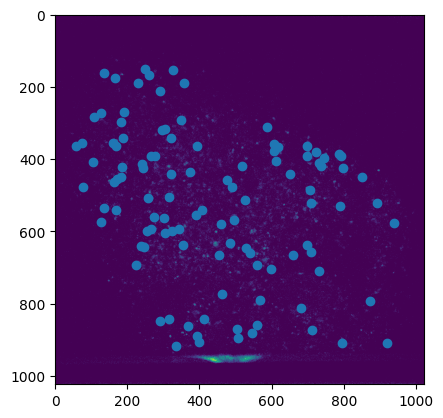

In [71]:
plt.imshow(video[0].reshape(video[0].shape[0], video[0].shape[1]))
plt.scatter(data_sequence[0]['points'][:,1], data_sequence[0]['points'][:,0])

In [ ]:
segmentation = detector.detect(video[0:5]) #, prob_thresh=detector.prob_threshold, nms_thresh=detector.nms_threshold, predict_kwargs={"verbose": 0})


In [ ]:
segmentation[0] #detections dataclass processes a frame of detections (mask) into centroids... this info is in data I believe

In [ ]:
plt.imshow(segmentation[0])

In [ ]:
detections_sequence[0][0].shape

In [ ]:
from byotrack.api.detector.detections import relabel_consecutive
import torch
relabel_consecutive(torch.tensor(detections_sequence[0], dtype=torch.int32))

In [ ]:
frame_ids=range(len(video))
for frame_id, detections in zip(frame_ids, detections_sequence):
    detections.frame_id = frame_id

In [ ]:
# print(detections_sequence[0].position.flip(1))

In [ ]:
#inspect all detections

#to inspect previously loaded detections - simply load the detections from a np array first

In [ ]:
#save tracks as np array

save_path_numpy = '/home/noah/Documents/NoahT2022/CodeRepos/Utopia/ExampleData/shortStack_adjusted/detections'
detection_array = np.asarray(detections_sequence)
np.save(save_path_numpy, detection_array, allow_pickle=True)

In [ ]:
# #save tracks as ImageJ ROIs
# save_path_IJ = '/home/noah/Documents/NoahT2022/CodeRepos/Utopia/ExampleOutputs'

# #detections objects do not contain polygon information, needs to be changed in byotracks or use stardist directly
# IJreshaped_rois = reshape_all_rois(detections_sequence)
# IJrois = convert_to_imageJ(IJreshaped_rois)


In [ ]:
#TODO

#add code for inspecting detections (same as setting parameters but easier)

#add code for saving detections in imageJ and numpy format

#add colours to plots so overlapping segments can be distinguished

#fix plotting so contours are continous and smoother - perhaps this was the case when I was using other methods...

In [ ]:
# imageJ roi style plotting

In [ ]:
# cell seg style plotting

In [ ]:
type(ijrois[0])

In [ ]:
plot_image_overlays(image, ijrois)
print(data.keys())

In [ ]:
img_n = cv2.normalize(src=image, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [ ]:
##cv contours
# image32 = image2.astype('uint8') #opencv needs float32, images loaded as float64 here :)
imagecv = cv2.cvtColor(img_n, cv2.COLOR_GRAY2BGR)

In [ ]:
contours,_ = cv2.findContours(imagecv[:,:,0],cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
np.shape(contours)

In [ ]:
data['coord'][0]

In [ ]:
contours[0][0][0][0]

In [ ]:
cvContours[0][0]

In [ ]:
plt.imshow(imagecv)
print(imagecv.shape)
print(imagecv.dtype)

In [ ]:
mask = np.zeros(imagecv.shape, np.uint8)
image_contours = imagecv.copy()
# Iterate over all contours
for i,c in enumerate(cvContours):
    try:
        # Find mean colour inside this contour by doing a masked mean
        # mask = np.zeros(image_contours.shape, np.uint8)
        # cv2.drawContours(mask,[c],-1,255, -1)
        # DEBUG: cv2.imwrite(f"mask-{i}.png",mask)
        # print(':)')
        # mean,_,_,_ = cv2.mean(imagecv, mask=mask)
        # DEBUG: print(f"i: {i}, mean: {mean}")

        # Get appropriate colour for this label
        # label = 2 if mean > 1.0 else 1
        colour = (0,255,255)
        # DEBUG: print(f"Colour: {colour}")
        print(c)

        # Outline contour in that colour on main image, line thickness=1
        cv2.drawContours(image_contours,[c],-1,colour,1)
    except Exception as e:
        print(e)

        break
try:
    cv2.namedWindow('contour', cv2.WINDOW_NORMAL)
    cv2.imshow('contour',image_contours) 

    cv2.waitKey(0)
    cv2.destroyAllWindows()
except Exception as e:
    print(e)
    cv2.destroyAllWindows()

# try:
#     cv2.drawContours(mask,[c],-1,255, -1)
# except Exception as e:
#     print(e)

In [ ]:
cv2.namedWindow('contour', cv2.WINDOW_NORMAL)
cv2.imshow('contour', imagecv)
cv2.waitKey(0)
  
# closing all open windows
cv2.destroyAllWindows()

In [ ]:
#evaluate model paramters on data

# Do not run this cell in order to keep the defaults prob_thresh and nms_thresh

#TODO: add roi funtionality to this so plotting shows mask over image (better evaluation) Will need to edit both stardist detector and the detector class .detect() function to include polygon data and add imageJ ROI code
vidCopy = video[0:50] #test batch
scale = 1

global frameID
frameID = 0
frame = video[frameID]
h, w = frame.shape[0:2]
global mask_glob
detection_zero = detector.run([vidCopy[frameID]])
mask_glob = (detection_zero[frameID].segmentation.numpy() != 0).astype(np.uint8) * 255

# window_name = 'Frame', f'Frame {frameID} / {len(detections_sequence_test)} - Number of detections: {len(detections_sequence_test[i])}'
window_name = 'Paramater Test - Segmentation   (Press Q to Quit)'

try:

    #create and rescale window
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, h*scale, w*scale)

    #Frame Trackbar
    def update_frame(x): #callback function for trackbar - default argument is the position of the track bar
        detections = detector.detect(vidCopy[x][None, ...])
        global mask_glob
        mask_glob = (detections[0].segmentation.numpy() != 0).astype(np.uint8) * 255
    cv2.createTrackbar('Frame',window_name,0,len(vidCopy)-1,update_frame)

    #Probability Trackbar
    def update_probability_threshold(x):
        detector.prob_threshold = (x+1)/100 
        update_frame(frameID)
    cv2.createTrackbar('Probability Threshold', window_name, 0, 99, update_probability_threshold)

    #Overlap Trackbar
    def update_overlap_threshold(x):
        detector.nms_threshold = (x+1)/100
        update_frame(frameID)
    cv2.createTrackbar('Overlap Threshold', window_name, 0, 99, update_overlap_threshold)

except Exception as e:
    print(e)


while True:
    try:

        frameID = cv2.getTrackbarPos('Frame',window_name)
        # cv2.imshow(window_name, video[frameID])
        cv2.imshow(window_name, mask_glob)

        probabilityThreshold = cv2.getTrackbarPos('Probability Threshold', window_name)/100
        nmsThreshold = cv2.getTrackbarPos('Overlap Threshold', window_name)/100

        #exit on q
        if cv2.waitKey(5) == ord('q'):
            # press q to terminate the loop
            cv2.destroyAllWindows()
            break

    except Exception as e:
        print(e)
        cv2.destroyAllWindows()
        break
    
cv2.destroyAllWindows()
print('Prob: ', probabilityThreshold)
print('nms: ', nmsThreshold)

In [ ]:
from roifile import ImagejRoi, ROI_TYPE, ROI_OPTIONS
roi = ImagejRoi.frompoints(coords)
roi.roitype = ROI_TYPE.POLYGON
roi.options |= ROI_OPTIONS.SHOW_LABELS

In [ ]:
#reader funtion for tif sequences - handles reshaping and normalising (using the stardist recommended normaliser) (doesn't seem to perform that well)
from csbdeep.utils import normalize as csbdeepNormaliser
    
def Read_Data_TIFseq(vid_path):
    # positions = (pd.read_csv(csv_path,usecols=['TrackID','t','x','y'])).values
    vid = iio.ImageCollection(vid_path + '/*.tif').concatenate() #concatonate to numpyarray #not concatenating allows for dynamic loading
    # red_vid = iio.ImageCollection(red_vid_path + '/*.tif')
    vid = vid.reshape(vid.shape[0], vid.shape[1], vid.shape[2], 1)
    normalisedVid = np.asarray([csbdeepNormaliser(frame) for frame in vid])
    return normalisedVid

video = Read_Data_TIFseq(tifpath)

In [ ]:
import colorsys
from scipy.ndimage.morphology import binary_dilation, binary_erosion
from skimage.morphology import disk
import random
import pandas as pd
from matplotlib.ticker import NullLocator

In [ ]:
#vis from cellseg

def get_bounding_box(masks):
    indices = np.where(masks != 0)
    values = masks[indices[0], indices[1]]
    maskframe = pd.DataFrame(np.transpose(np.array([indices[0], indices[1], values]))).rename(columns = {0:"y", 1:"x", 2:"id"})
    bb_mins = maskframe.groupby('id').agg({'y': 'min', 'x': 'min'}).to_records(index = False).tolist()
    bb_maxes = maskframe.groupby('id').agg({'y': 'max', 'x': 'max'}).to_records(index = False).tolist()
    
    return bb_mins, bb_maxes



def compute_snippet_bounds(minY, minX, maxY, maxX, Y, X):
    if minX < 0: minX = 0
    if minY < 0: minY = 0
    if maxX >= X: maxX = X - 1
    if maxY >= Y: maxY = Y - 1
        
    return minY, minX, maxY, maxX


def extract_snippet(Y, X, masks, mins, maxes):
    
    minY, minX, maxY, maxX = compute_snippet_bounds(mins[0] - 1, mins[1] - 1, maxes[0] + 1, maxes[1] + 1, Y, X)
        
    return masks[(minY):(maxY), (minX):(maxX)], minY, minX, maxY, maxX

def get_mask_ids(masks):
    maskids = list(np.unique(masks))
    maskids.remove(0)
    maskids.sort()
    
    return maskids

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    colors = [(int(i[0] * 255), int(i[1] * 255), int(i[2] * 255)) for i in colors]
    random.shuffle(colors)
    return colors

def generate_mask_outlines(masks):
    
    #first compute bounding boxes
    maskids = get_mask_ids(masks)
    num_masks = len(maskids)

    bb_mins, bb_maxes = get_bounding_box(masks)

    Y, X = masks.shape

    output_im = np.zeros(masks.shape, dtype = np.uint32)

    struc = disk(1)
    for i, maskid in enumerate(maskids):

        currreg, minY, minX, maxY, maxX = extract_snippet(Y, X, masks, bb_mins[i], bb_maxes[i])

        mask_snippet = (currreg == maskid)
        interior = binary_erosion(mask_snippet, struc)
        boundary = mask_snippet ^ interior

        pix_to_update = np.nonzero(boundary)

        pix_X = np.array([min(j + minX, X) for j in pix_to_update[1]])
        pix_Y = np.array([min(j + minY, Y) for j in pix_to_update[0]])

        output_im[pix_Y, pix_X] = maskid

    return output_im
    
def overlay_outlines_and_save(image, masks, outputpath, figsize, colors = None):
    
    auto_show = False
    _, ax = plt.subplots(1, figsize=figsize)

    maskids = get_mask_ids(masks)
    num_masks = len(maskids)

    # Generate random colors
    colors = colors or random_colors(num_masks)

    bb_mins, bb_maxes = get_bounding_box(masks)

    #rgb_im = cv2.cvtColor(nimage, cv2.COLOR_GRAY2RGB)
    rgb_im = image

    rgb_im = rgb_im.astype(np.uint8)

    Y, X = masks.shape

    for i, maskid in enumerate(maskids):

        currreg, minY, minX, maxY, maxX = extract_snippet(Y, X, masks, bb_mins[i], bb_maxes[i])
        mask_snippet = (currreg == maskid)


        color = colors[i]
        #if i < 10:
        #    print(color)
        #    plt.imshow(mask_snippet)
       #     plt.show()
       #     plt.close()
        pix_to_update = np.nonzero(mask_snippet)

        #minY, minX, maxY, maxX = compute_snippet_bounds(bb_mins[i][0] - 1, bb_mins[i][1] - 1, bb_maxes[i][0] + 1, bb_maxes[i][1] + 1, Y, X)

        pix_X = np.array([min(j + minX, X) for j in pix_to_update[1]])
        pix_Y = np.array([min(j + minY, Y) for j in pix_to_update[0]])

        rgb_im[pix_Y, pix_X, :] = color
        #rgb_im[pix_Y, pix_X, 1] = 255
        #rgb_im[pix_Y, pix_X, 2] = 255

    ax.axis('off')
    img = ax.imshow(rgb_im)
    # This is needed to remove all whitespace
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.savefig(outputpath, dpi=75)
    plt.close()

In [ ]:
def maskplotter(image, segmentation, colors = None):

    # image=image.reshape(image.shape[0], image.shape[1])
    masks = segmentation
    maskids = get_mask_ids(masks)
    num_masks = len(maskids)

    # Generate random colors
    colors = colors or random_colors(num_masks)

    bb_mins, bb_maxes = get_bounding_box(masks)

    #rgb_im = cv2.cvtColor(nimage, cv2.COLOR_GRAY2RGB)
    rgb_im = image

    rgb_im = rgb_im.astype(np.uint8)
    print(rgb_im.shape)

    Y, X = masks.shape

    for i, maskid in enumerate(maskids):

        currreg, minY, minX, maxY, maxX = extract_snippet(Y, X, masks, bb_mins[i], bb_maxes[i])
        mask_snippet = (currreg == maskid)


        color = colors[i]
        #if i < 10:
        #    print(color)
        #    plt.imshow(mask_snippet)
        #     plt.show()
        #     plt.close()
        pix_to_update = np.nonzero(mask_snippet)

        #minY, minX, maxY, maxX = compute_snippet_bounds(bb_mins[i][0] - 1, bb_mins[i][1] - 1, bb_maxes[i][0] + 1, bb_maxes[i][1] + 1, Y, X)

        pix_X = np.array([min(j + minX, X) for j in pix_to_update[1]])
        pix_Y = np.array([min(j + minY, Y) for j in pix_to_update[0]])

        rgb_im[pix_Y, pix_X, :] = color

    return rgb_im

In [ ]:
dummy = np.zeros(image.shape)
img2 = cv2.merge((dummy,image,dummy))

In [ ]:
plt.imshow(img2)
plt.show()

In [ ]:
mask = (segmentation != 0).astype(np.uint8) * 255
masksim  = generate_mask_outlines(mask)
colorMaskIm = maskplotter(img2, mask)

In [ ]:
import tifffile
path = '/home/noah/Desktop/cellsegtest/segTestNew/shortStack_adjusted/camera2_NDTiffStack0002.tif'
image = np.array(tifffile.imread(path))
image = image.reshape(image.shape[0], image.shape[1], 1)
print(image.shape)
shape = image.shape
SHAPE = (shape[1], shape[2], shape[0])
image = np.transpose(image, (1, 2, 0))
image = image.reshape(SHAPE)

image.shape



In [ ]:
overlay_outlines_and_save(image, mask, '/home/noah/Documents/NoahT2022/CodeRepos/Utopia/ExampleData', (30,30), colors = None)

In [ ]:
_, ax = plt.subplots(1)
ax.axis('off')
img = ax.imshow(colorMaskIm)
# This is needed to remove all whitespace
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(NullLocator())
plt.gca().yaxis.set_major_locator(NullLocator())
# plt.savefig(outputpath, dpi=75)
plt.show()

In [ ]:
newim = masksim + image.reshape(image.shape[0], image.shape[1])
print(masksim.shape)
print(image.shape)
print(newim.shape)
plt.imshow(newim)
plt.axis('off')
plt.show()

In [ ]:
imgmask = cv2.merge((newim,dummy,dummy))
plt.imshow(imgmask)
plt.show()

In [ ]:
idx=~(masksim==0)
# newim = np.where(idx, image[::,0], image[::,0])
# newim2 = np.putmask(image[::,0], idx, 255)

indx = idx.nonzero()
newim3 = image.reshape(image.shape[0], image.shape[1])
newim3 = img2
print(newim3.shape)
newim3[indx][2] = 0.5
plt.imshow(newim3[::])
plt.show()

print(newim3.max())
print(newim3.shape)


In [ ]:
newim.shape
plt.imshow(idx)
idx

In [ ]:
plt.imshow(newim)